# Projeto de Ciência de Dados Airbnb Rio de Janeiro

Projeto de Ciência de Dados seguindo o curso de Python Impressionador - Hashtag Treinamentos

## Contexto
<p>No Airbnb, qualquer indivíduo que possua um quarto ou propriedade de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode oferecê-lo para aluguel por diária.</p>
<p>Nesse sentido, a pessoa cria um perfil de host (quem disponibiliza a propriedade para aluguel) e elabora o anúncio do imóvel. Nele, o host descreve as características do local de maneira abrangente, auxiliando os locatários/viajantes na escolha do lugar ideal e tornando a propriedade mais atrativa.</p>
<p>O anúncio oferece diversas opções de personalização, que engloba desde a quantidade mínima de diárias, preço e número de quartos, até regras de cancelamento, taxa adicional para hóspedes extras, a necessidade de verificação de identidade do locatário, entre outras possibilidades.</p>

## Objetivo do Projeto
<p>Construir um modelo de previsão de preço que permita que um host possa saber quanto deve cobrar pela diária do seu imóvel ou que um locador possa saber se os preços estão atrativos (abaixo da média para imóveis com as mesma características) ou não para alugar.</p>

## Importar Bibliotecas e Bases de Dados

In [1]:
import pandas as pd
import pathlib  # também existe a biblioteca glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
caminho_projeto = r'/content/drive/MyDrive/Data-Science-Project'
caminho_bases = pathlib.Path(caminho_projeto + '/dataset')

meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

base_airbnb = pd.DataFrame()
for arquivo in caminho_bases.iterdir():
    if 'total' in arquivo.name:
        continue
    df_aux = pd.read_csv(arquivo)
    df_aux['arquivo'] = arquivo.name[:-4]
    df_aux['month'] = meses[arquivo.name[:3]]
    df_aux['year'] = int(arquivo.name[-8:-4])
    base_airbnb = pd.concat([base_airbnb, df_aux])


In [4]:
display(base_airbnb)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,14063,https://www.airbnb.com/rooms/14063,20180414160018,2018-04-14,Living in a Postcard,"Besides the most iconic's view, our apartment ...",NaN,"Besides the most iconic's view, our apartment ...",none,Best and favorite neighborhood of Rio. Perfect...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17878,https://www.airbnb.com/rooms/17878,20180414160018,2018-04-14,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24480,https://www.airbnb.com/rooms/24480,20180414160018,2018-04-14,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,The studio is located at Vinicius de Moraes St...,My studio is located in the best of Ipanema. ...,none,"The beach, the lagoon, Ipanema is a great loca...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25026,https://www.airbnb.com/rooms/25026,20180414160018,2018-04-14,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31560,https://www.airbnb.com/rooms/31560,20180414160018,2018-04-14,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,38844730,https://www.airbnb.com/rooms/38844730,20190923212307,2019-09-24,TRANSAMERICA BARRA DA TIJUCA R IV,"Em estilo contemporâneo, o Transamerica Prime ...",NaN,"Em estilo contemporâneo, o Transamerica Prime ...",none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,15.0,0.0,0.0
34325,38846408,https://www.airbnb.com/rooms/38846408,20190923212307,2019-09-24,Alugo para o Rock in Rio,"Confortável apartamento, 2 quartos , sendo 1 s...",O apartamento estará com mobília completa disp...,"Confortável apartamento, 2 quartos , sendo 1 s...",none,"Muito próximo ao Parque Olímpico, local do eve...",...,2.0,2.0,1125.0,1125.0,2.0,1125.0,0.0,1.0,0.0,0.0
34326,38846703,https://www.airbnb.com/rooms/38846703,20190923212307,2019-09-24,Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA,Apartamento quarto e sala COMPLETO para curtas...,Espaço ideal para até 5 pessoas. Cama de casal...,Apartamento quarto e sala COMPLETO para curtas...,none,NaN,...,3.0,3.0,1125.0,1125.0,3.0,1125.0,0.0,23.0,6.0,0.0
34327,38847050,https://www.airbnb.com/rooms/38847050,20190923212307,2019-09-24,Cobertura Cinematografica,Cobertura alto nivel,NaN,Cobertura alto nivel,none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,1.0,0.0,0.0


## Limpeza da Base de Dados
- Como a base de dados tem muitas colunas, o modelo possivelmente ficará bem lento.
- Uma análise rápida já permite perceber que várias colunas não são necessárias para treinar o modelo de previsão.
- Por isso, vamos excluir algumas colunas
- Tipos de colunas que vamos excluir:
    1. Colunas de identificações: IDs, links, informações não relevantes para o modelo
    2. Colunas repetidas ou muito parecidas (Ex: Data x Ano/Mês, Várias sobre a localização)
    3. Colunas de texto livre -> não rodaremos nenhuma análise de palavras
    4. Colunas em que todos ou quase todos os valores são iguais

- Para isso, vamos criar um arquivo em excel com os 1.000 primeiros registros e fazer uma análise qualitativa


In [5]:
# célula executada apenas uma vez
# base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')

In [6]:
print(base_airbnb['experiences_offered'].value_counts())
print(base_airbnb['host_acceptance_rate'].value_counts())

none    902210
Name: experiences_offered, dtype: int64
100%    31697
0%       4744
50%      3781
99%      3320
67%      3140
        ...  
28%        22
15%        21
7%         20
51%        18
6%         11
Name: host_acceptance_rate, Length: 100, dtype: int64


In [7]:
# comparar colunas
print((base_airbnb['host_listings_count'] == base_airbnb['host_total_listings_count']).value_counts())

True     901750
False       460
dtype: int64


In [8]:
print(base_airbnb['square_feet'].isnull().sum())  # muitos dados vazios

888162


Depois da análise qualitativa das colunas, levando com consideração os critérios explicados anteriormente. Ficamos com as seguintes 34 colunas:

In [9]:
primeiros_registros = pd.read_csv(caminho_projeto + '/primeiros_registros.csv', sep=';')
colunas = list(primeiros_registros.columns)
base_airbnb = base_airbnb[colunas]
display(base_airbnb)

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,month,year
0,NaN,NaN,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,...,9.0,9.0,9.0,9.0,9.0,f,f,strict_14_with_grace_period,4,2018
1,within an hour,100%,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,...,9.0,10.0,10.0,9.0,9.0,t,f,strict,4,2018
2,within an hour,100%,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,4,2018
3,within an hour,100%,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,4,2018
4,within an hour,100%,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict,4,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,within an hour,93%,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,9,2019
34325,NaN,NaN,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,9,2019
34326,within a few hours,74%,f,32.0,-22.962080,-43.175520,Apartment,Entire home/apt,5,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,9,2019
34327,NaN,NaN,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,9,2019


## Tratando de Valores Vazios (NaN)

Primeiramente, vamos analisar quais colunas tem valor NaN e quantidade de valores Nan que temos

A partir disso, temos três opções:
1. Exluir as colunas com muitos valores NaN
2. Excluir as linhas com valores NaN
3. Substituir o valor NaN com algum valor específico

In [10]:
# Analisar a quantidade de valores NaN em cada coluna
print(base_airbnb.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

In [11]:
# excluir as colunas com 300 mil ou mais valores NaN
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300_000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)


# excluir linhas com valores NaN
base_airbnb = base_airbnb.dropna()

# agora temos uma base de dados sem valores NaN
print(base_airbnb.isnull().sum())

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
month                       0
year                        0
dtype: int64


## Verificar Tipos de Dados em cada coluna

Isso é muito importante para o modelo de previsão. <br>
O modelo de previsão age de maneiras diferentes para cada tipo de dado, então é importante que o mês esteja sendo entendido, de fato, como um número, que o ano seja um número e assim por diante.

In [12]:
print(base_airbnb.dtypes)
print('-'*60)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
month                         int64
year                          int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                           f
host_listings_count

- Com essa análise, podemos ver que as colunas "price" e "extra_people" estão sendo reconhecidos como objetos (ou string), quando deveriam ser tratadas como float.
- Isso se deve a 2 fatos:
    1. Tem o símbolo "$" em cada célula dessas colunas
    2. O separador de milhar é uma vírgula (2,000 -> dois mil), o que não funciona para linguagem de programação
- Então precisamos tratar mudar o tipo de dado.

In [13]:
# price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '', regex=False)
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '', regex=False)
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)

# extra_people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '', regex=False)
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '', regex=False)
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)

# Verificando os tipos
print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
month                         int64
year                          int64
dtype: object


## Análise Exploratória e Tratar Outliers
- Vamos basicamente olhar feature por feature para:
    1. Examinar a correlação entre as features e decidir se manteremos todas que temos
    2. Excluir outliers -> utilizaremos as regras de <a href="https://statplace.com.br/blog/como-interpretar-um-boxplot/#:~:text=Sendo%20assim%2C%20os%20limites%20inferior,(Terceiro%20Quartil%20%E2%80%93%20Primeiro%20Quartil)">Limite Superior e Inferior</a> para construção de um boxplot em Estatística.
        - LI = Q1 - 1.5 * (Q3 - Q1)
        - LS = Q4 + 1.5 * (Q3 + Q1)
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e devemos excluir

- Vamos começas pelas colunas de valores contínuos (como "price" e "extra_people")
- Depois, vamos analisar as colunas com valores discretos (como "accomodates", "bedroom", ...)
- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido termos ou não

**CUIDADO**: não excluir os outliers de imediato, os analisaremos primeiramente. Se não tem motivo claro para remover o outlier, talvez não seja necessário e pode até ser prejudicial para a generalização. -> é claro que poderia testar com o outlier e sem o outlier para ver qual o melhor, mas fazer isso para cada feature é bem trabalhoso e nada eficiente.

Exemplo de análise: se o objetivo é ajudar a precificar um imóvel que está querendo disponibilizar, excluir outliers em "host_listings_count" pode fazer sentido. Agora, para uma empresa com uma série de propriedades que quer comparar com outras empresas do tipo, talvez excluir outliers pode não fazer sentido. -> Pensar sempre no nosso *objetivo*!

<Axes: >

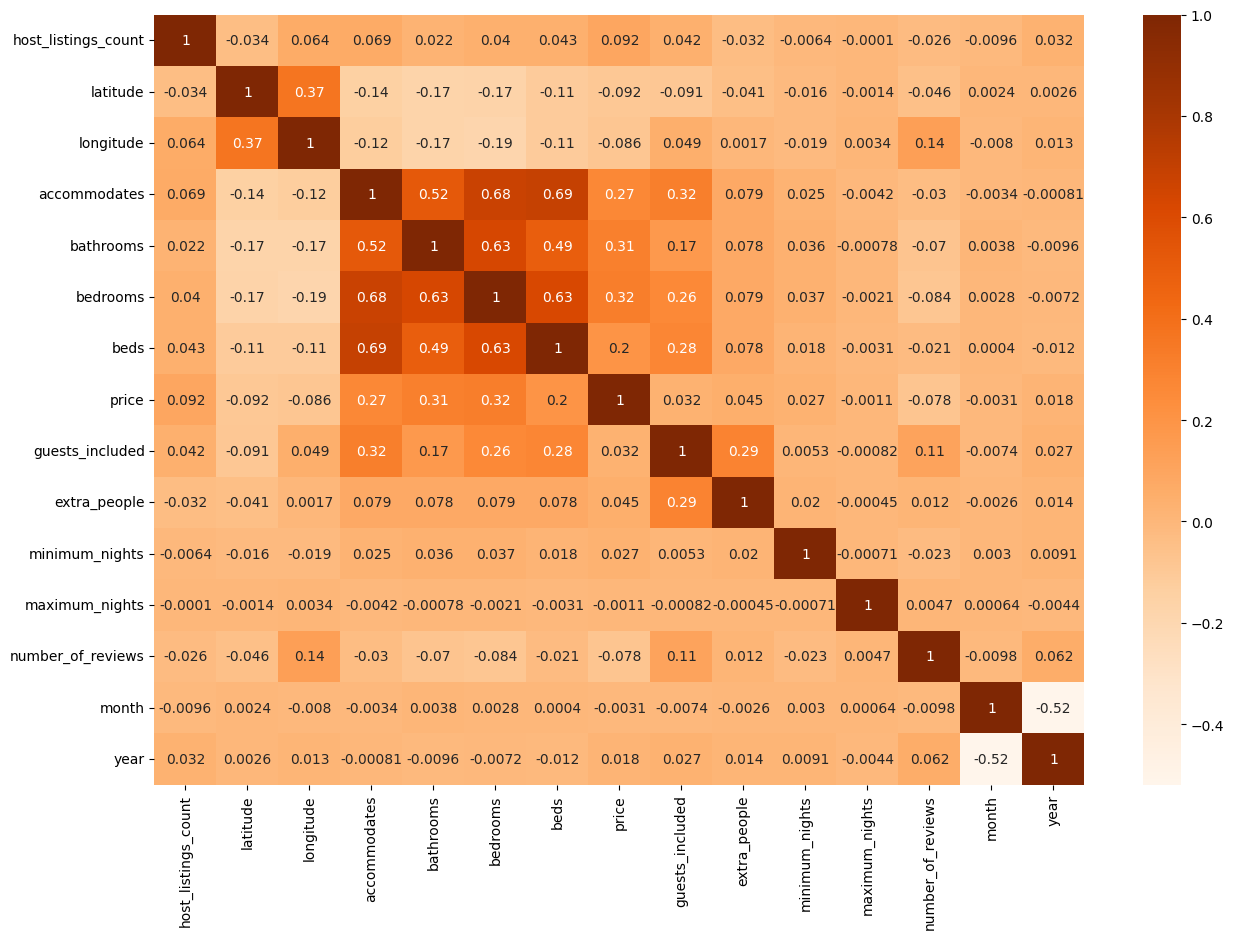

In [14]:
# Correlação utilizando um mapa de calor para melhor visualização
plt.figure(figsize=(15, 10))
sns.heatmap(base_airbnb.corr(numeric_only=True), annot=True, cmap="Oranges")

### Definição de funções para Análise Explorativa

Vamos definir algumas funções para ajudar na análise de outliers das colunas:
- limites: calcula os limites inferior e superior
- boxplot: plota um diagrama de caixa (boxplot) dos dados passados -> boxplot nos mostra onde está a maioria dos nosso dados
- histograma: plota um gráfico de histograma dos dados passados -> como aquela série de dados se comporta  

In [15]:
# função para calcular limites inferior e superior
def limites(coluna):
    '''
    coluna: é uma coluna de um DataFrame do pandas
    '''
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3-q1
    li = q1 - 1.5*amplitude
    ls = q3 + 1.5*amplitude

    return (li, ls)


# função para excluir outliers
def excluir_outliers(df, nome_coluna):
    qtd_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtd_linhas - df.shape[0]
    return df, linhas_removidas


# função para plotar o boxplot
def boxplot(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)  # ax1 é o eixo do primeiro gráfico, ax2 do segundo gráfico
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)


# função para plotar histograma
def histograma(coluna):
    plt.figure(figsize=(15, 5))
    b = (coluna.value_counts()).shape[0]
    sns.histplot(coluna, bins=b//10, kde=True, kde_kws=dict(cut=3), stat='density', alpha=.4, edgecolor=(1, 1, 1, .4))


# função de gráfico de barras
def grafico_barra(coluna):
    plt.figure(figsize=(15, 5))
    li, ls = limites(coluna)
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts(), color='salmon')
    ax.set_xlim(li, ls + 1.5 * (ls-li))

### Coluna price

Tirar ou não os outliers? <br>
Vamos sim tirar outliers de price nesse projeto, uma vez que nosso objetivo é prever o preço de futuras diárias para imóveis comuns. Esses lugares que estão com preços muito maiores, provavelmente, são lugares altíssimo luxo.

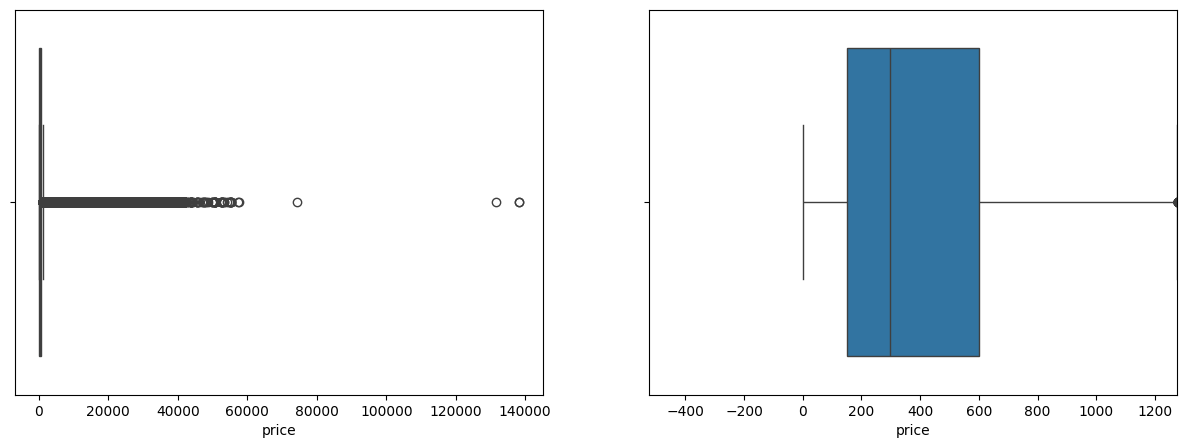

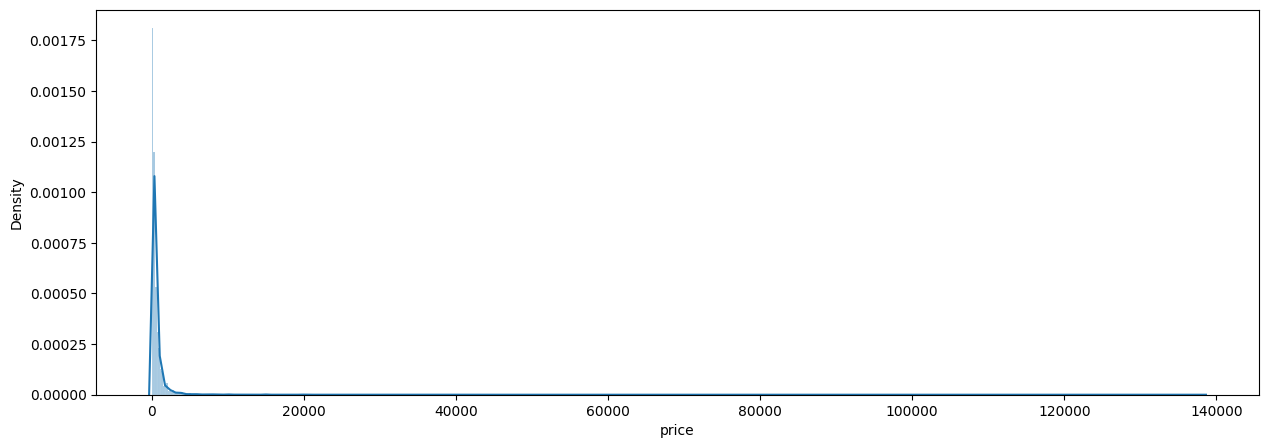

In [16]:
boxplot(base_airbnb['price'])
histograma(base_airbnb['price'])

In [17]:
base_airbnb, linhas_excluidas = excluir_outliers(base_airbnb, 'price')

print(f"{linhas_excluidas} linhas removidas")

87282 linhas removidas


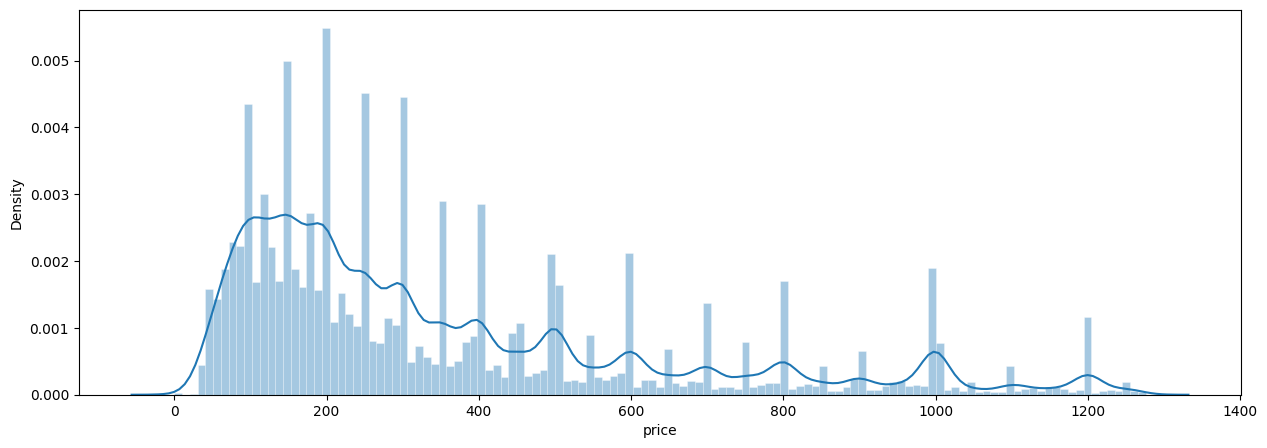

In [18]:
histograma(base_airbnb['price'])

### Coluna extra_people

Tirar ou não tirar outliers? <br>
Nesse projeto vamos excluir os outliers do extra_people. Podemos testar no final com os outliers de extra people.

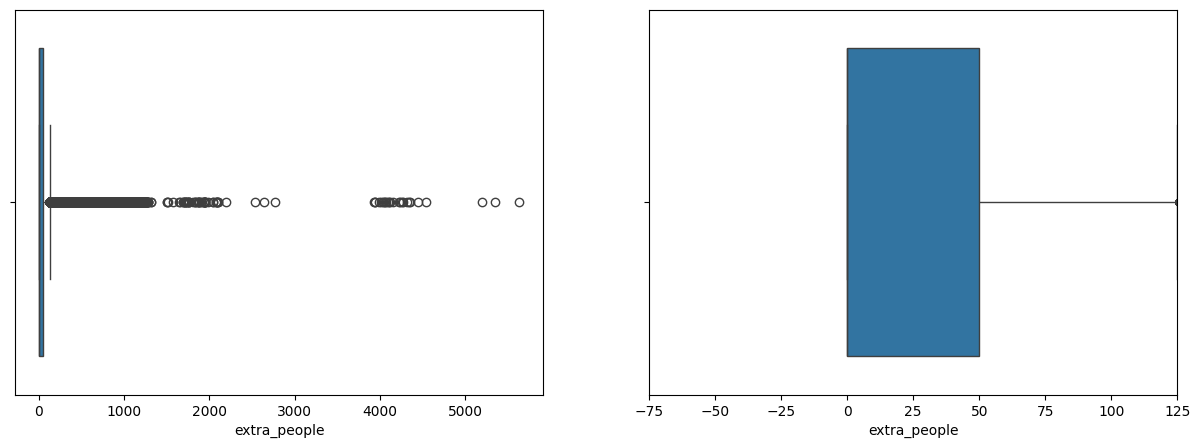

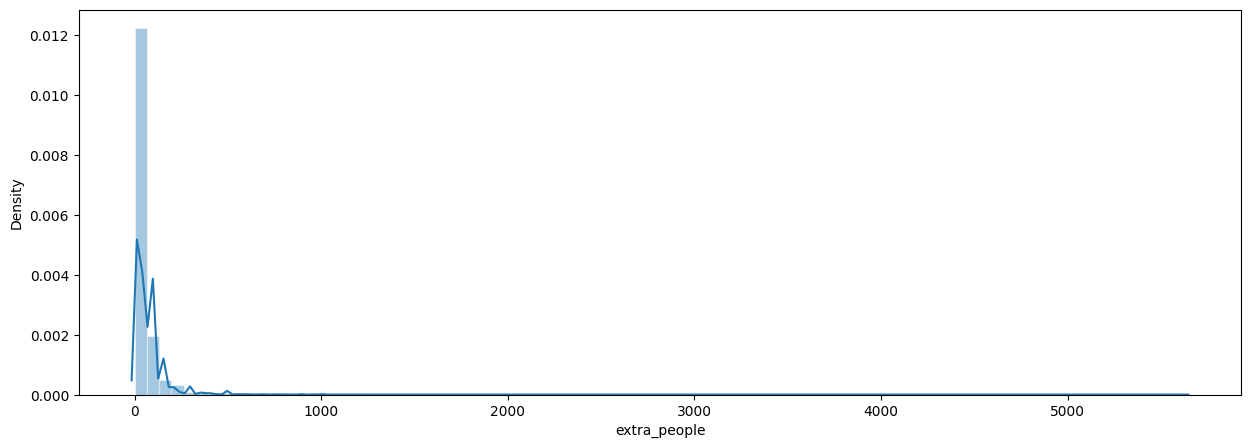

In [19]:
boxplot(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [20]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print(f"{linhas_removidas} linhas removidas")

59194 linhas removidas


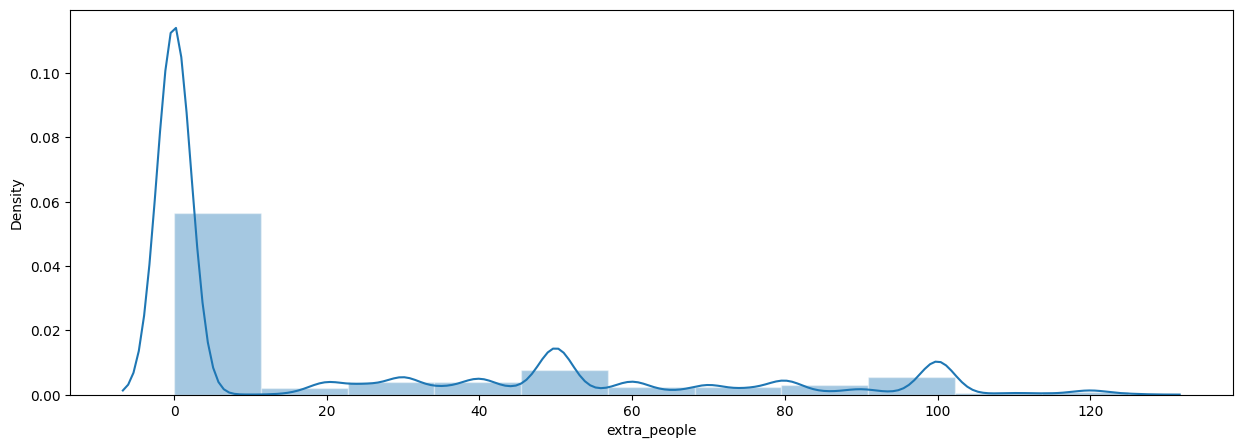

In [21]:
histograma(base_airbnb['extra_people'])

### Coluna host_listings_count

host_listings_count -> quantos imóveis a pessoa tem disponível no airbnb

Podemos excluir os outliers, porque hosts com mais de 6 imóveis no airbnb nãp está no público alvo do objetivo do projeto (talvez seja imobiliárias ou profissionais que gereciam isso)

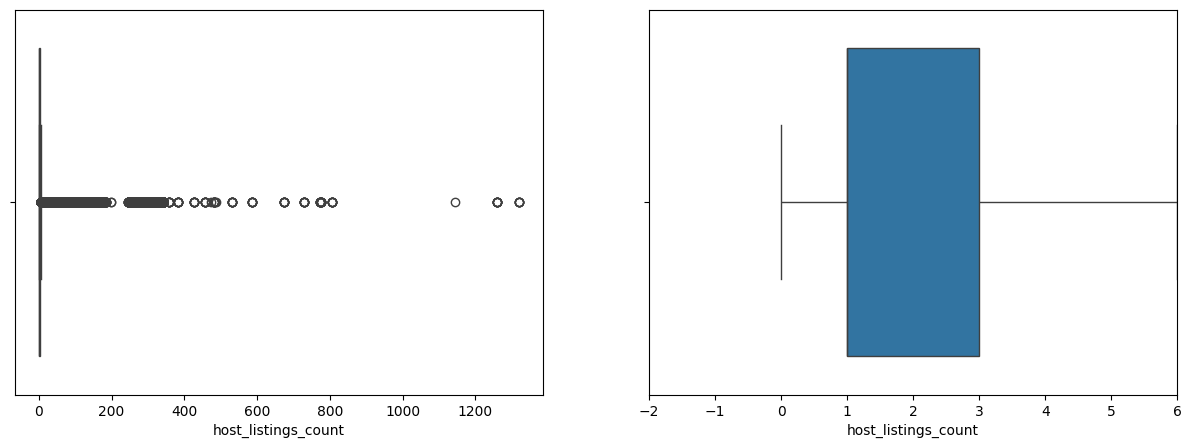

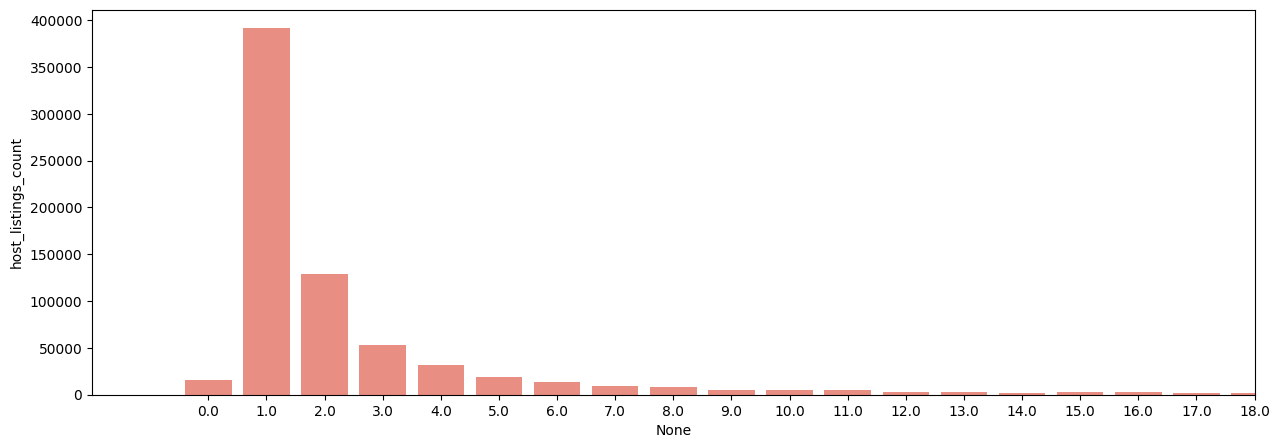

In [22]:
boxplot(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

In [23]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print(f"{linhas_removidas} linhas removidas")

97723 linhas removidas


### Coluna accommodates

Temos poucos outliers, então também excluiremos.

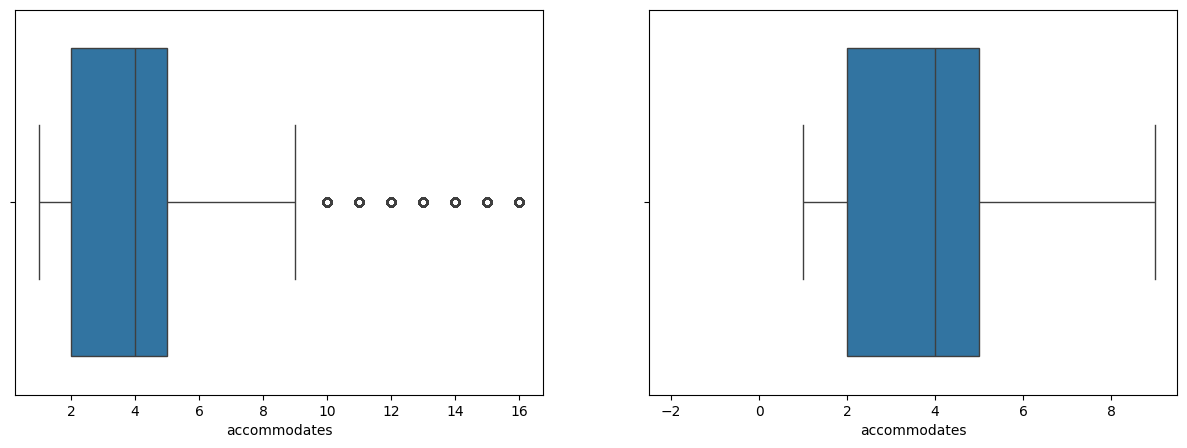

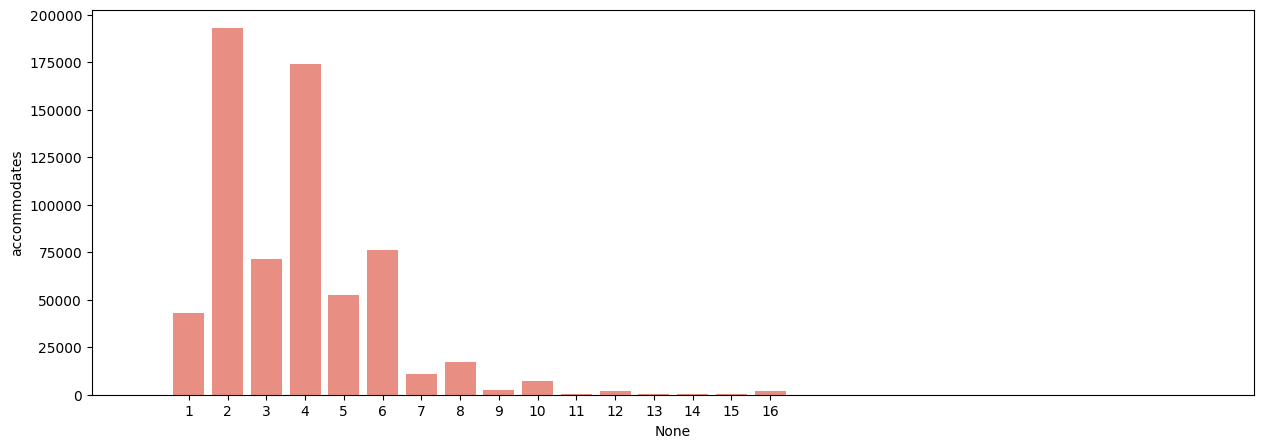

In [24]:
boxplot(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

In [25]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print(f"{linhas_removidas} linhas removidas")

13146 linhas removidas


### Coluna bathrooms

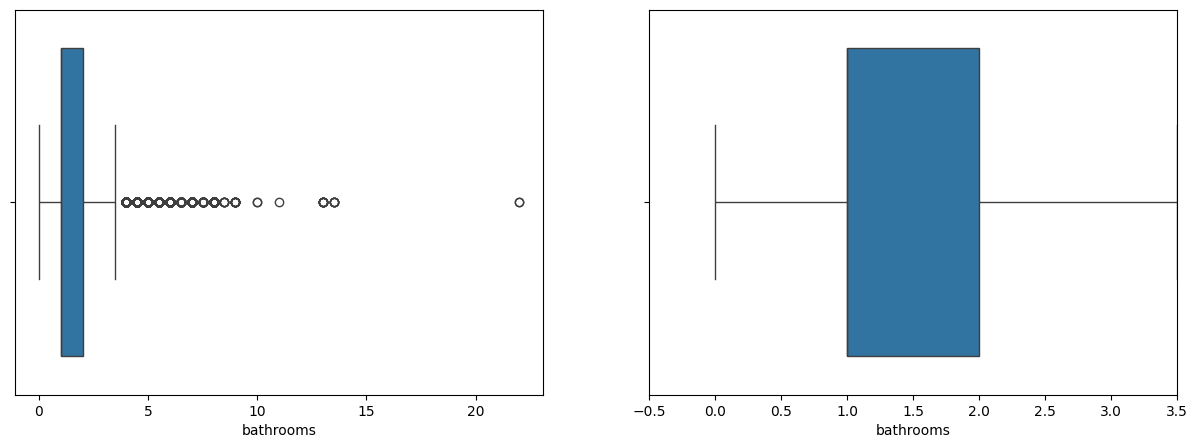

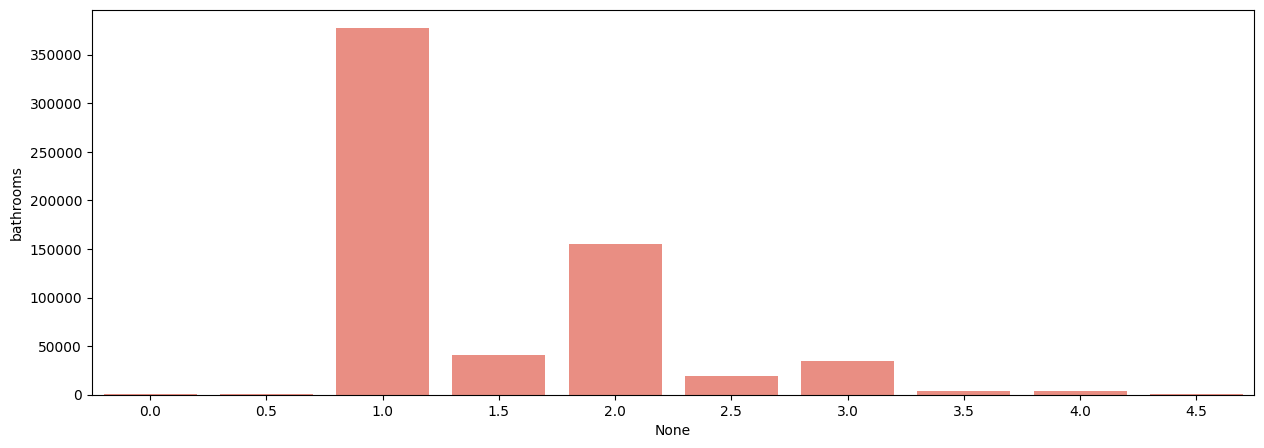

In [26]:
boxplot(base_airbnb['bathrooms'])
grafico_barra(base_airbnb['bathrooms'])

In [27]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print(f"{linhas_removidas} linhas removidas")

6894 linhas removidas


### Coluna bedrooms

Poucos outliers, podemos retirá-los.

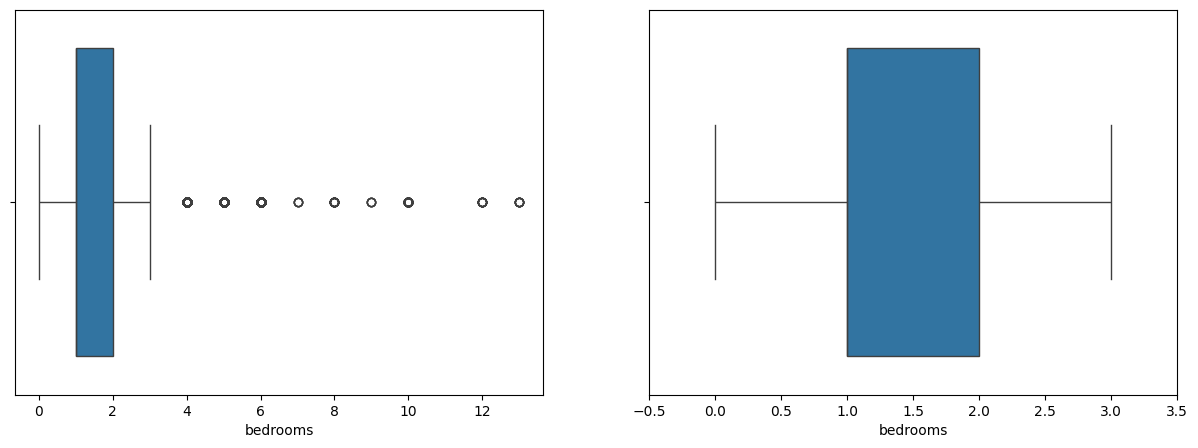

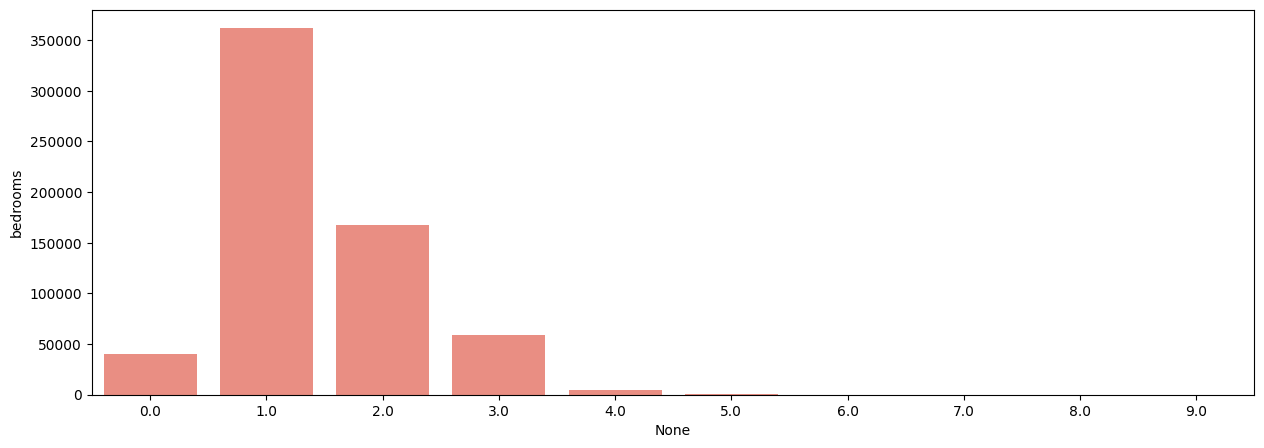

In [28]:
boxplot(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

In [29]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print(f"{linhas_removidas} linhas removidas")

5482 linhas removidas


### Coluna beds

Poucos outliers, podemos retirá-los.

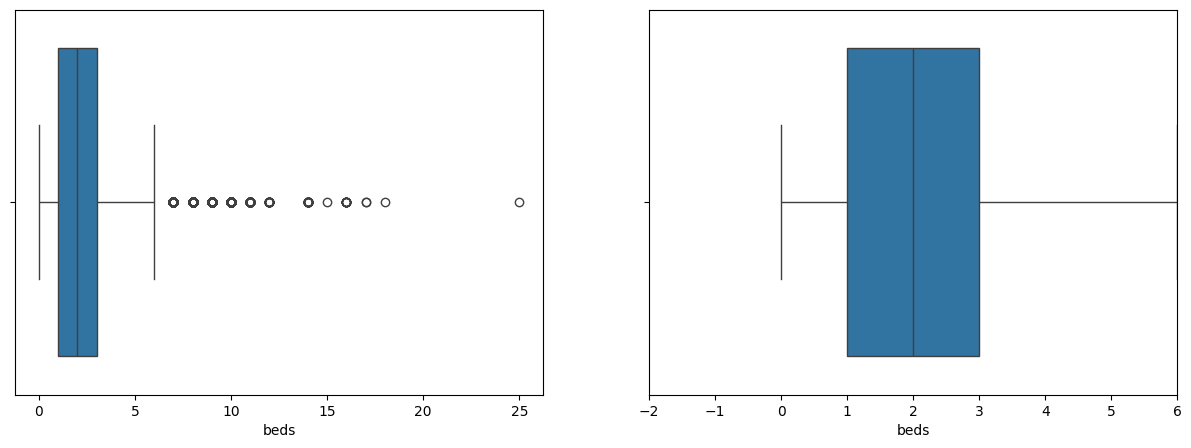

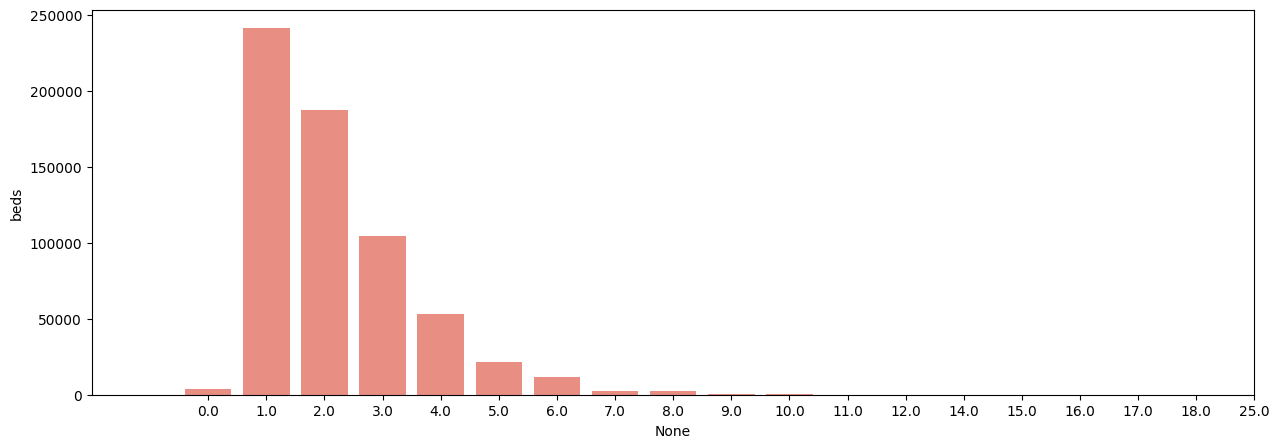

In [30]:
boxplot(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

In [31]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print(f"{linhas_removidas} linhas removidas")

5622 linhas removidas


### Coluna guests_included

guests_included -> quantas pessoas já estão incluídas no pacote quando é paga a diária

(1.0, 1.0)


<Axes: xlabel='None', ylabel='guests_included'>

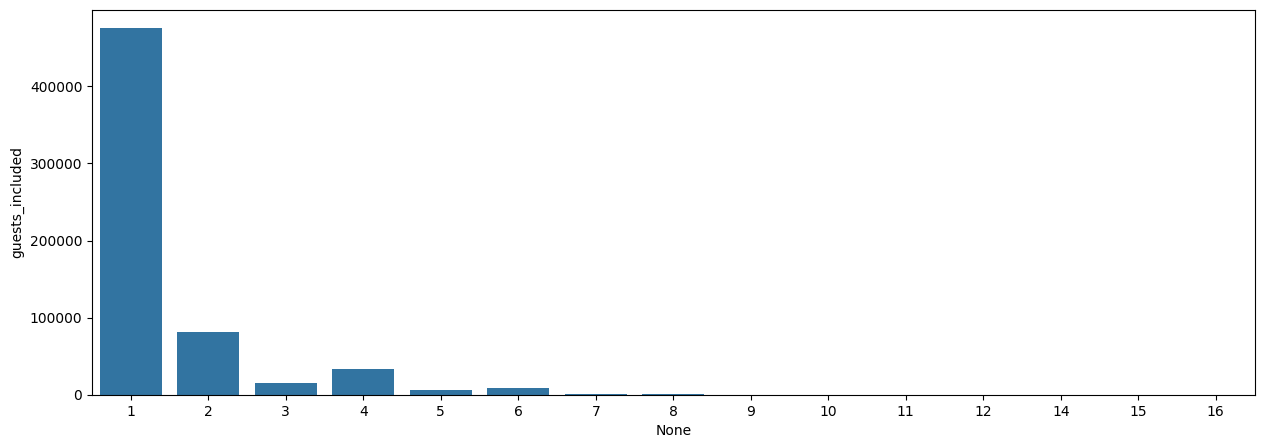

In [32]:
print(limites(base_airbnb['guests_included']))
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

Limite Inferior == Limite Superior -> a maioria dos imóveis tem somente 1 pessoa incluída <br>
<br>
Será que faz sentido incluir apenas 1 pessoa para o aluguel de uma **casa** ou um **apartamento**? Esses dados não estão coerente, e isso pode ser tavez um erro de preenchimento na hora de colocar o imóvel para alugar. <br>
<br>
Por este motivo, removeremos por completo essa feature da análise.

In [33]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(622366, 22)

### Coluna minimum_nights

minimum_nights -> quantidade mínima de noites que pode ser alugado

Imóveis que só podem ser alugados por no mínimo longos periodos como, por exemplo, 15 dias, não são alvos do objetivo do projeto. Então, removeremos os outliers.

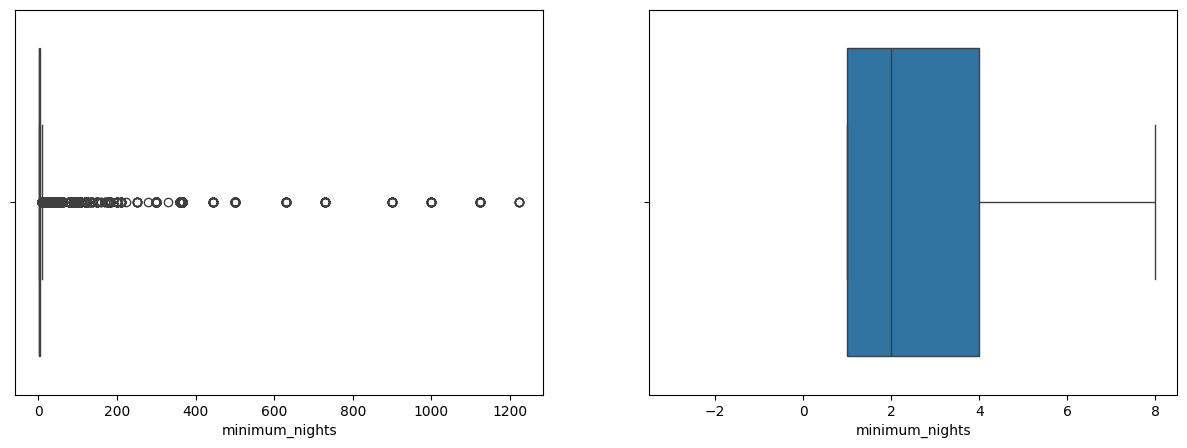

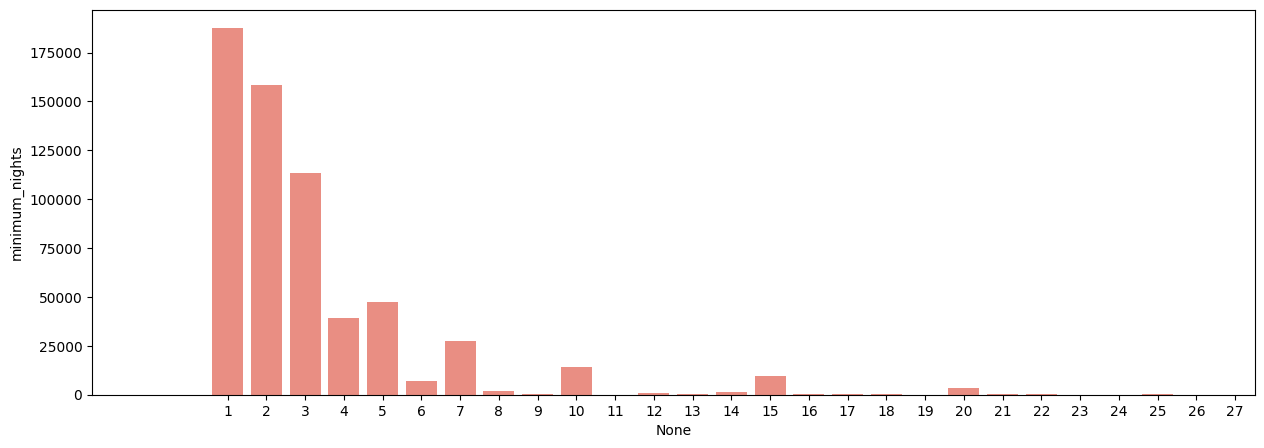

In [34]:
boxplot(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

In [35]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print(f"{linhas_removidas} linhas removidas")

40383 linhas removidas


### Coluna maximum_nights

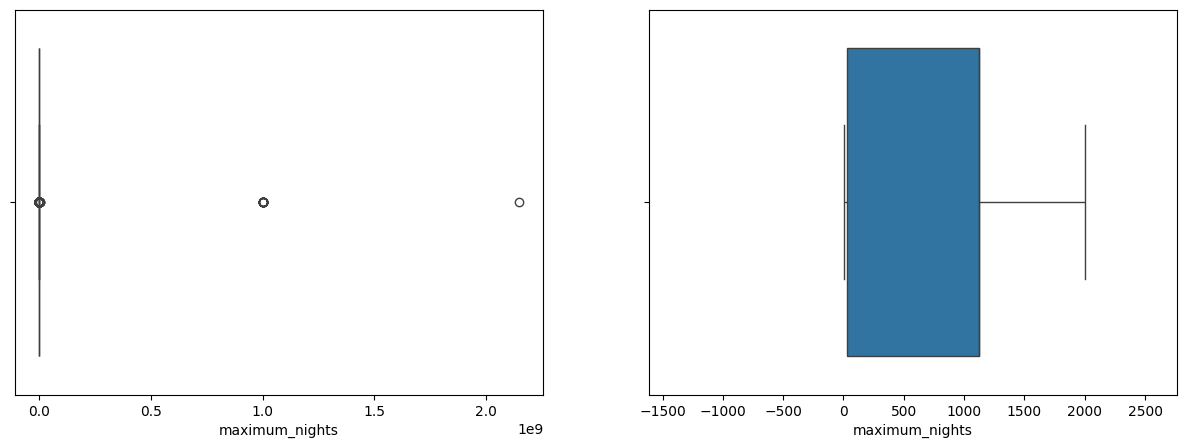

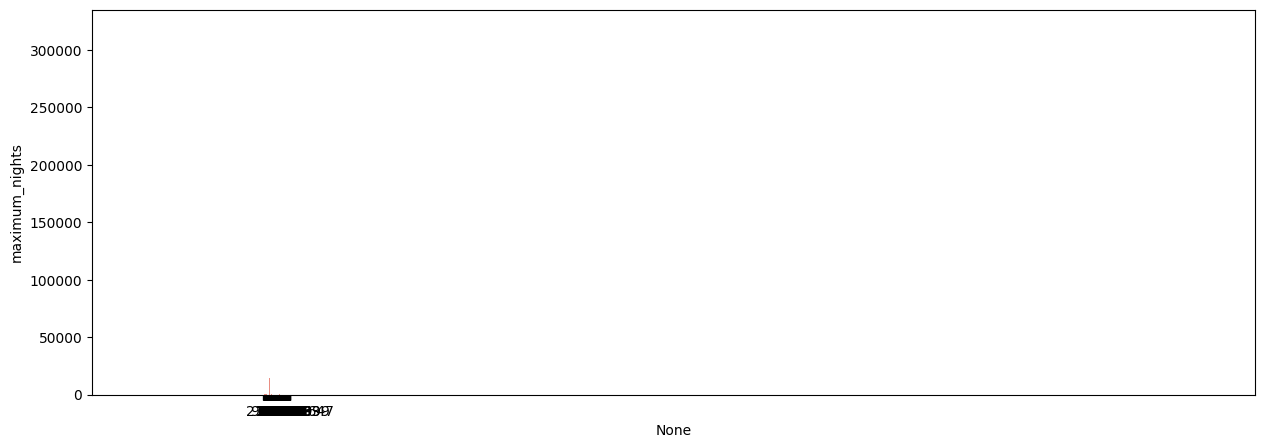

In [36]:
boxplot(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

Quantidade máxima de noites, intuitivamente, não influencia muito no preço. Quando olhamos para os gráfico acima, percebemos isso de fato, visto que exitem muitos valores muito grandes, por exemplo 1000. <br>
<br>
Por esse motivo, tiraremos essa feature por completo da nossa análise.

In [37]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(581983, 21)

### Coluna number_of_reviews

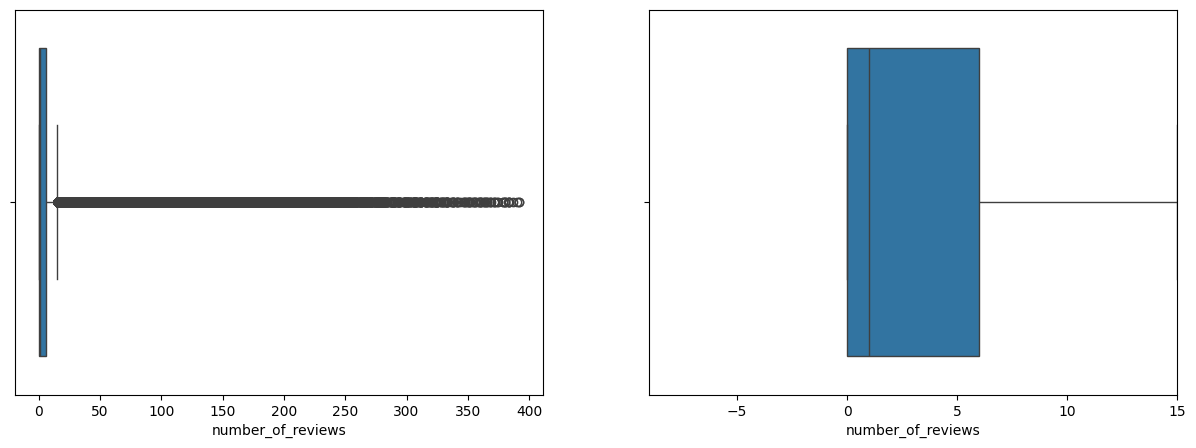

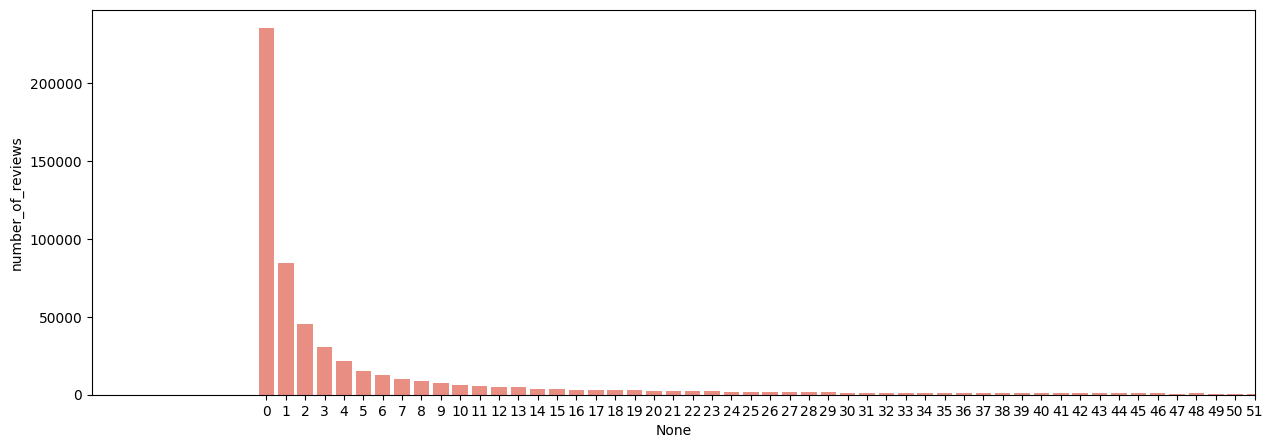

In [38]:
boxplot(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

Excluir os outliers aqui seria excluir os hosts com muitas reviews, possivelmente reviews muito boas, o que não faz muito sentido. <br>
<br>
A melhor escolha, visando o objetivo do projeto, é retirar por completo essa feature. Queremos que uma pessoa que ainda não disponibilizou seu imóvel no airbnb possa saber qual valor colocar na diária do seu imóvel. Uma pessoa recém chegada na plataforma não terá muitos reviews.

In [39]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(581983, 20)

### Coluna property_type
Vamos observar a quantidade que se repete cada valor dessa coluna e ver quais valem a pena criar de fator uma categoria. Com isso em mente, vamos colocar os valores que aparecem menos de 2 mil vezes na categoria "outros".

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

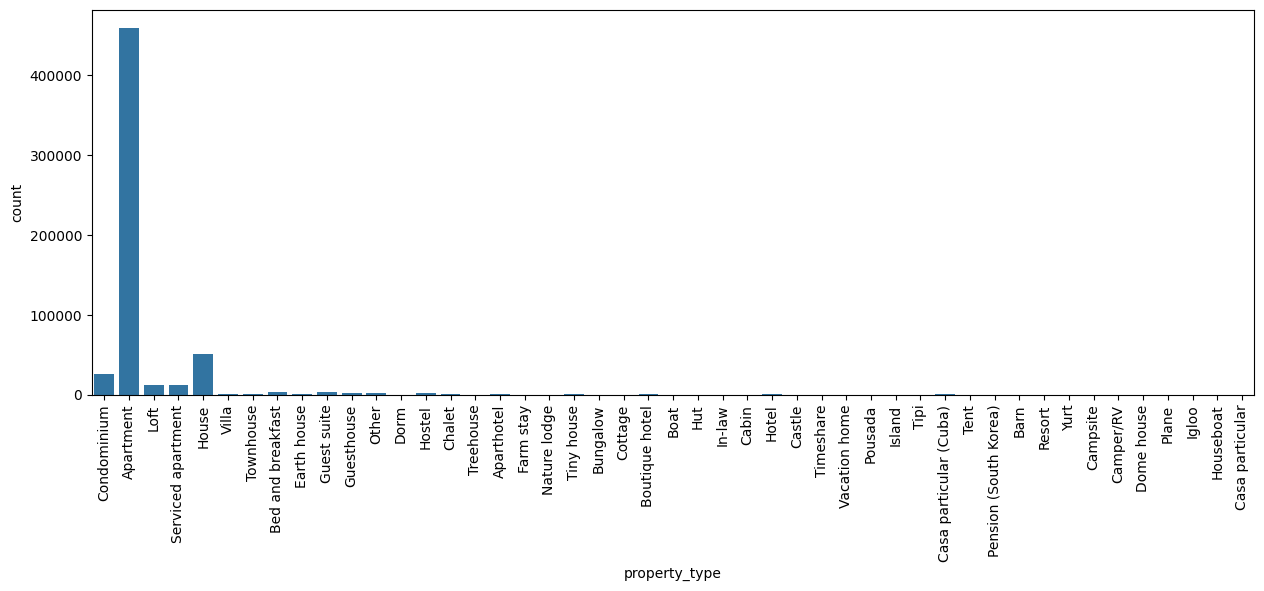

In [40]:
print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(x=base_airbnb['property_type'])
grafico.tick_params(axis='x', rotation=90)

Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: property_type, dtype: int64


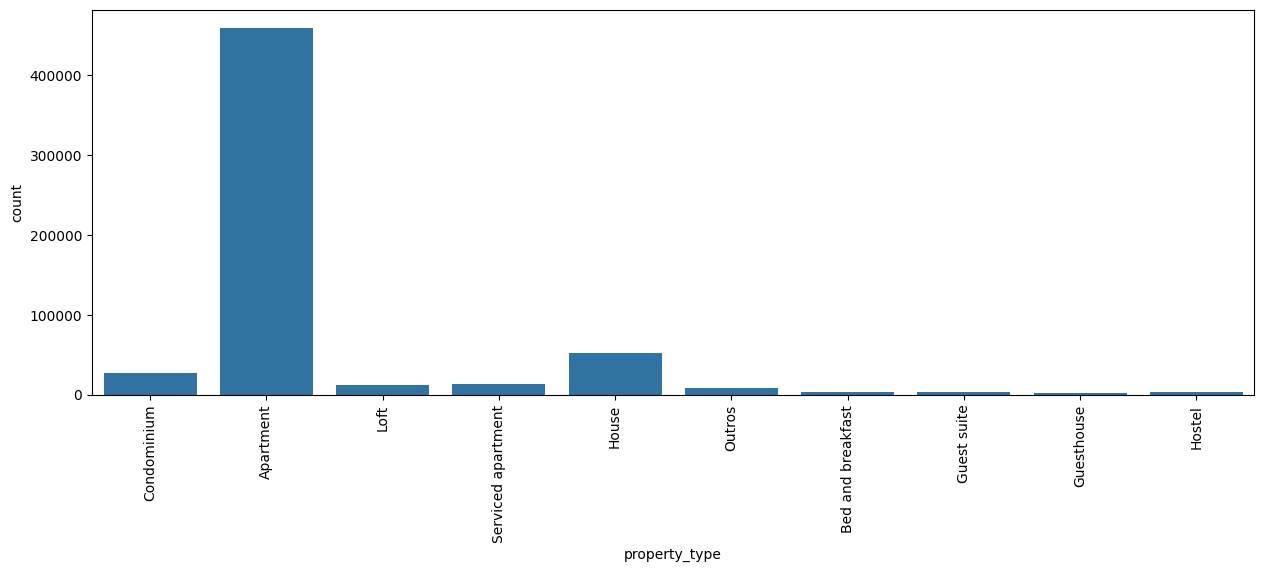

In [41]:
tabela_tipos_casa = base_airbnb['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2000:
        colunas_agrupar.append(tipo)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type'] == tipo, 'property_type'] = 'Outros'

print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(x=base_airbnb['property_type'])
grafico.tick_params(axis='x', rotation=90)

### Coluna room_type
São apenas 4 categorias, então não precisaremos fazer nenhuma mudança

Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: room_type, dtype: int64


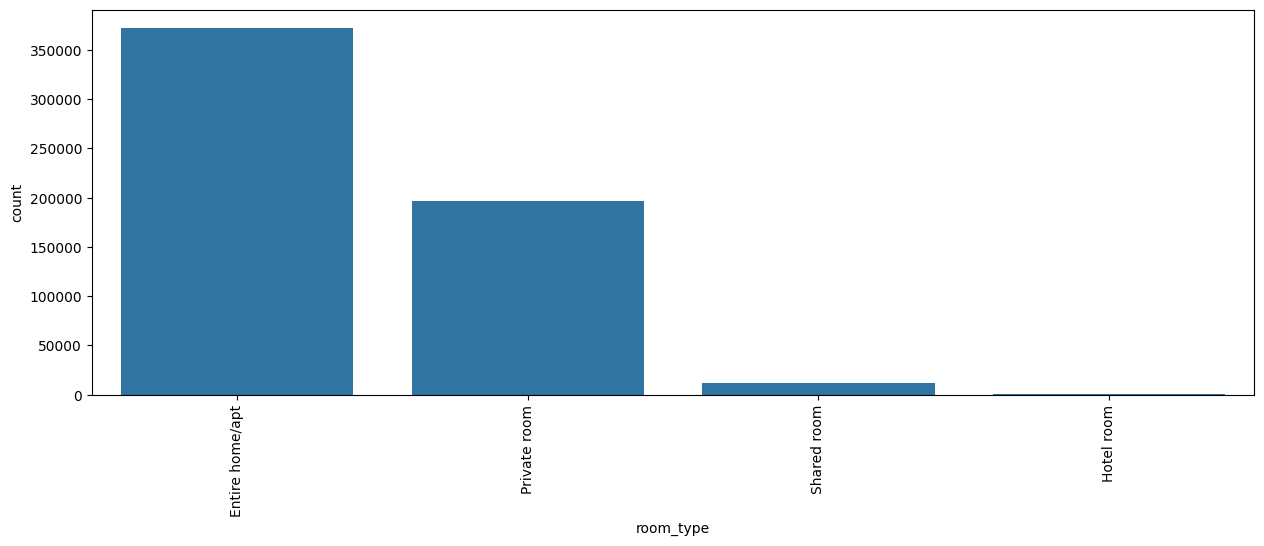

In [42]:
print(base_airbnb['room_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(x=base_airbnb['room_type'])
grafico.tick_params(axis='x', rotation=90)

### Coluna bed_type

Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: bed_type, dtype: int64


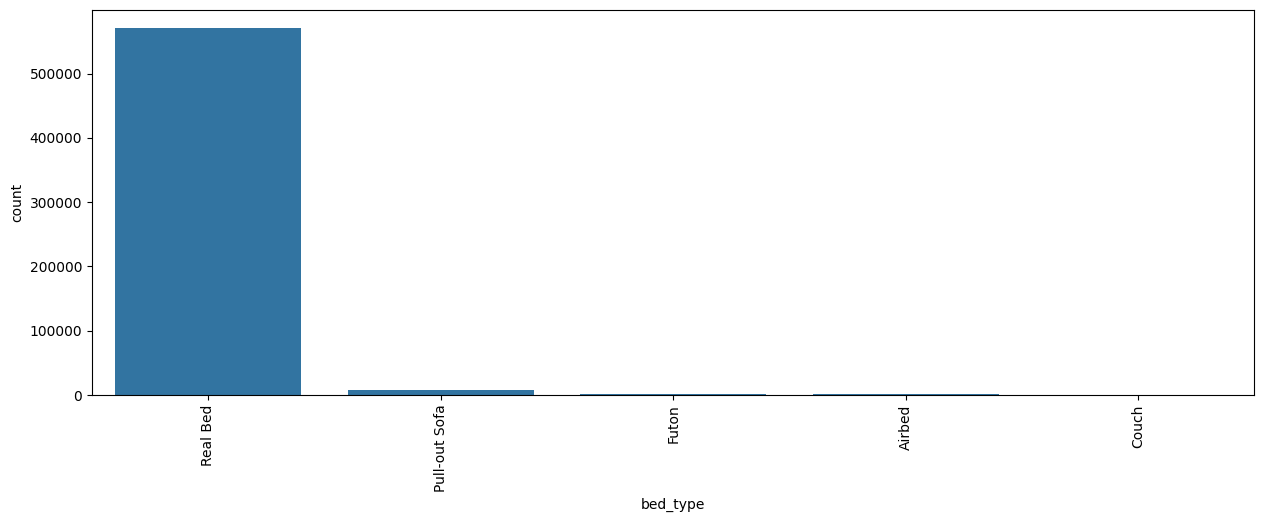

In [43]:
print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(x=base_airbnb['bed_type'])
grafico.tick_params(axis='x', rotation=90)

Como as outras categorias diferentes de "Real Bed" tem valores bem menores e discrepantes, vamos agrupá-las em uma categoria só

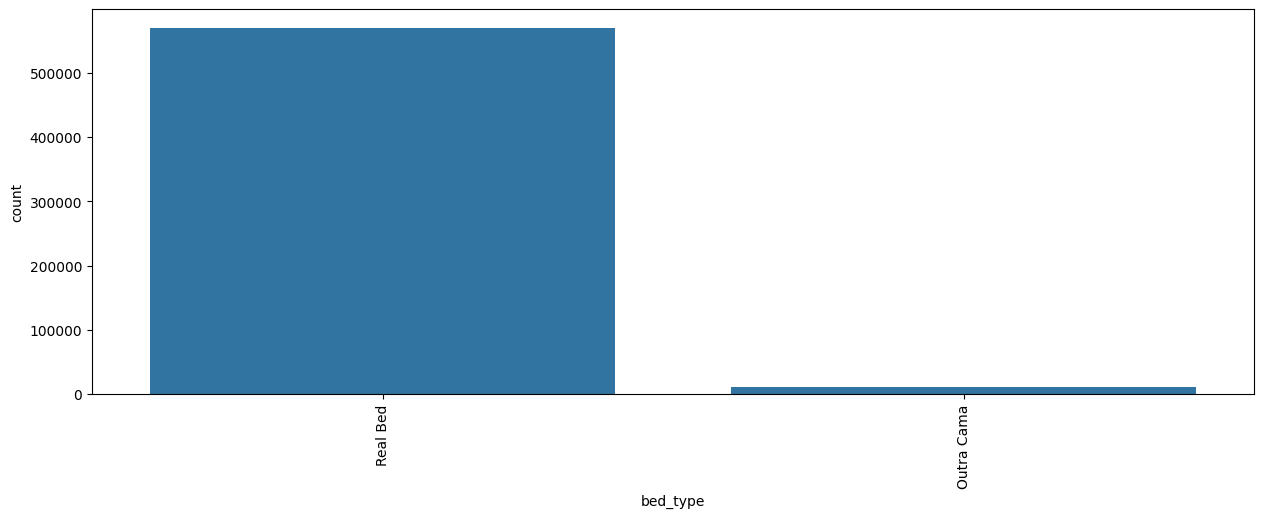

In [44]:
base_airbnb.loc[base_airbnb['bed_type'] != 'Real Bed', 'bed_type'] = 'Outra Cama'

plt.figure(figsize=(15, 5))
grafico = sns.countplot(x=base_airbnb['bed_type'])
grafico.tick_params(axis='x', rotation=90)

### Coluna cancellation_policy

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: cancellation_policy, dtype: int64


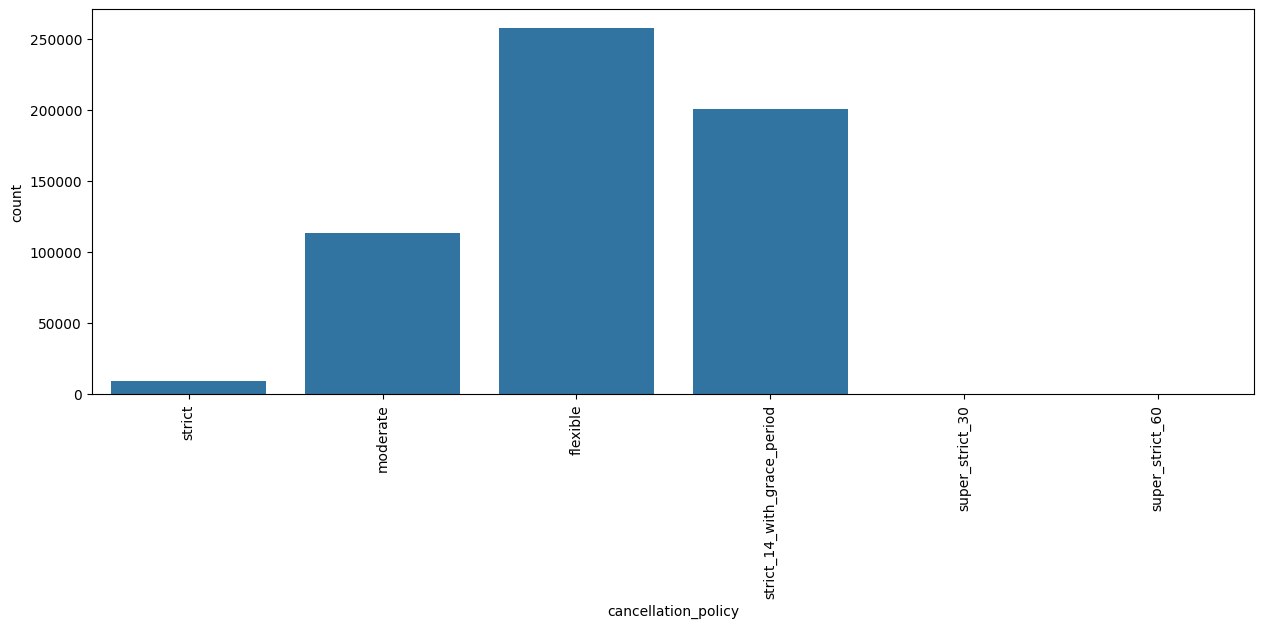

In [45]:
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(x=base_airbnb['cancellation_policy'])
grafico.tick_params(axis='x', rotation=90)

Aqui, como temos 3 categorias com valores bem menores e discrepantes das outras, então os agruparemos.

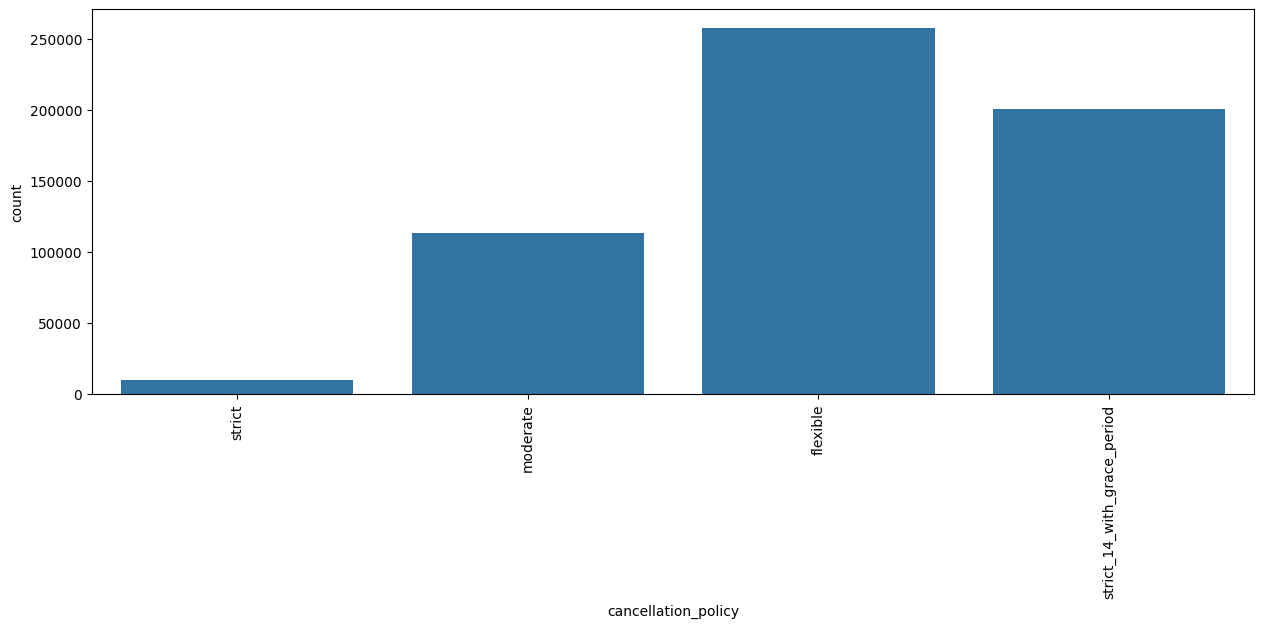

In [46]:
tabela_tipo_cancelamento = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipo_cancelamento.index:
    if tabela_tipo_cancelamento[tipo] < 10_000:
        colunas_agrupar.append(tipo)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy'] == tipo, 'cancellation_policy'] = 'strict'

# gráfico final
plt.figure(figsize=(15, 5))
grafico = sns.countplot(x=base_airbnb['cancellation_policy'])
grafico.tick_params(axis='x', rotation=90)

### Coluna amenities

In [47]:
print(base_airbnb['amenities'].iloc[0])

{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,"Paid parking off premises","Smoking allowed",Doorman,Elevator,"Hot tub","Family/kid friendly","Suitable for events",Essentials,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Self check-in","Front desk/doorperson","Private entrance","Hot water","Bed linens","Luggage dropoff allowed"}


Como temos uma diversidade muito grande de amenities enfrentamos um problema: é muito difícil comparar característica por característca e como elas, individualmente, influenciam o preço do imóvel. <br>
Isso porque é um campo que o próprio host preenche no formulário, então um host pode achar relevante colocar que tem elevador, por exemplo, e outro pode achar que não seja necessário. Além disso, podemos ter variações de escrita para a mesma característica de um imóvel, por exemplo, "Tv" e "televisão". <br>
<br>
Consideraremos, para essa análise, a seguinte premissa: hosts que detalham mais sobre o seu imóvel, isto é, hosts que se esforçam mais na criação do anúncio, mostram um serviço melhor, uma preocupação um pouco maior com o locatário e o imóvel também pode, de fato, ter mais comodidades, o que pode impactar diretamente no preço <br>
<br>
Para isso, utilizaremos a quantidade de amenities, ao invés dos textos descrevendo os amenities

In [48]:
base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(581983, 20)

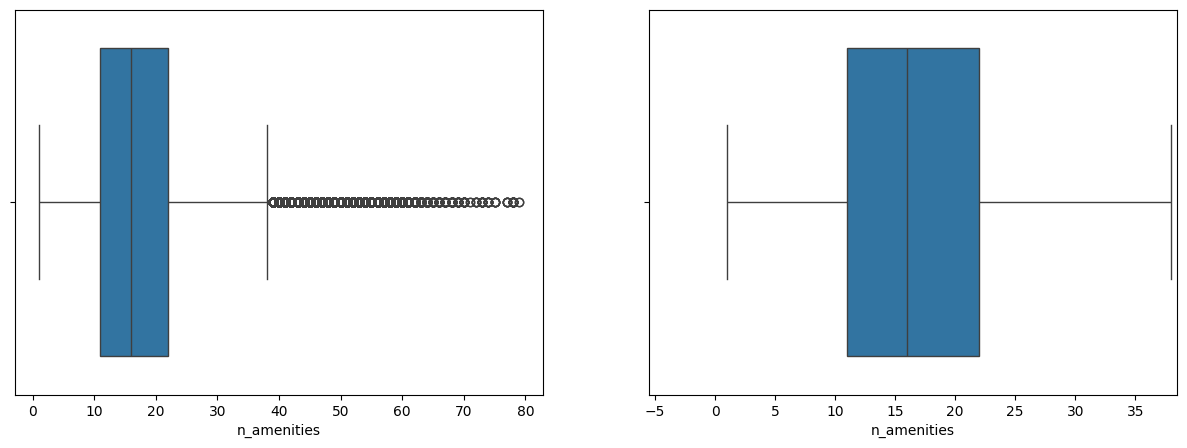

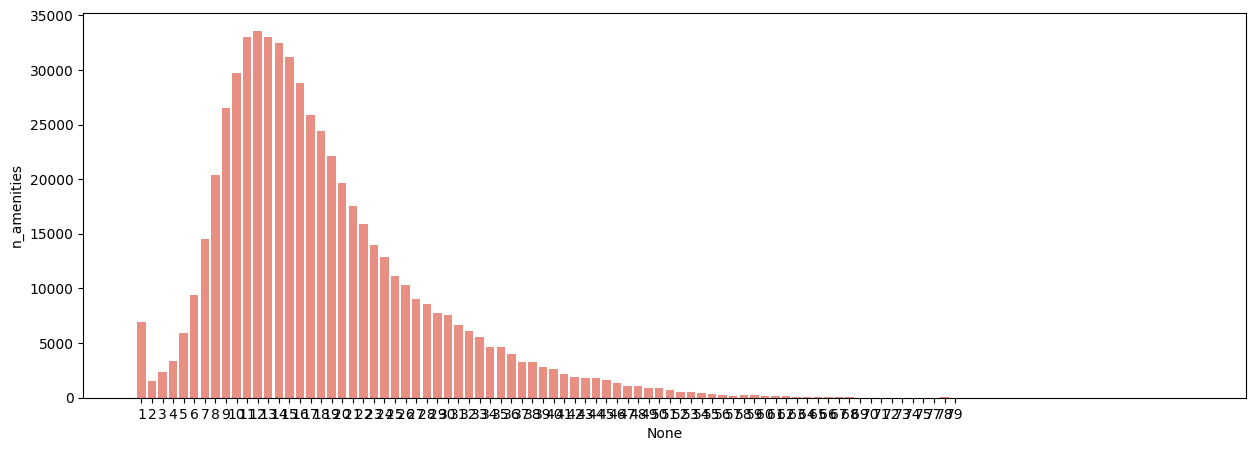

In [49]:
boxplot(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

In [50]:
# excluir outliers
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print(f"{linhas_removidas} linhas removidas")

24343 linhas removidas


### Visualização de mapa das propriedades
Colunas Latitude e Longitude -> utilizaremos a biblioteca plotly para criação de mapa interativo

In [51]:
amostra = base_airbnb.sample(n=50_000)  # escolher uma amostra para não ficar tão pesada a criação do mapa
centro_mapa = {'lat': amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
fig = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price', radius=2.5,
                         center=centro_mapa, zoom=10, mapbox_style='open-street-map')
fig.show()


### Encoding
Precisamos ajustar as features para facilitar o trabalho do modelo futuro
- Features True ou False -> substituir True = 1 e Falso = 0

In [52]:
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']

base_airbnb_cod = base_airbnb.copy()
for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna] == 't', coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna] == 'f', coluna] = 0

In [53]:
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']

# transformando algumas colunas em dummies
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias)
display(base_airbnb_cod.head())

,host_is_superhost,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Outra Cama,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period
1,1,2.0,-22.965919,-43.178962,5,1.0,2.0,2.0,270.0,51.0,...,1,0,0,0,0,1,0,0,1,0
3,0,3.0,-22.977117,-43.190454,3,1.0,1.0,2.0,161.0,45.0,...,1,0,0,0,0,1,0,0,1,0
4,1,1.0,-22.983024,-43.214270,3,1.0,1.0,2.0,222.0,68.0,...,1,0,0,0,0,1,0,0,1,0
5,1,1.0,-22.988165,-43.193588,3,1.5,1.0,2.0,308.0,86.0,...,1,0,0,0,0,1,0,0,1,0
6,1,1.0,-22.981269,-43.190457,2,1.0,1.0,2.0,219.0,80.0,...,1,0,0,0,0,1,0,0,1,0


### Panorama Geral da Análise Exploratória Feita
1. Análise da Correlação entre as features
2. Funções para ajudar na Análise
3. Análise quantitativa e qualitativa de cada coluna (feature) numérica
4. Análise quantitativa e qualitativa de cada coluna (feature) categóricas
5. Análise em mapa da latitude e longitude em relação ao preço
6. Encoding de Colunas True ou False e Colunas de Categorias

## Contruir um Modelo de Previsão

Modelo de Previsão
- Nosso objetivo: prever o preço da diária dos imóveis
- O modelo é como se fosse uma equação (y = ax + b)

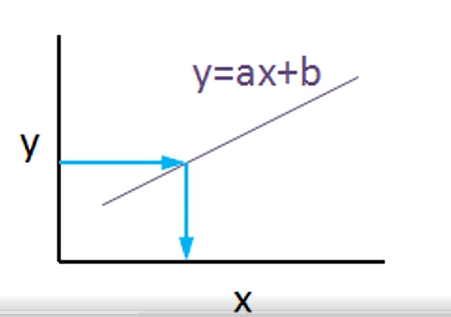

- Em nosso caso temos várias variáveis:
    - y = preço, x1 = quartos, x2 = camas, ....
    - eq: y = a.x1 + b.x2 + ... + z
- Vamos utilizar Machine Learning para chegar nessa equação

## Passos para Criar/Treinar um Modelo
1. Definir se é Classificação ou Regressão
2. Escolher as métricas para avaliar o Modelo
3. Escolher quais Modelos vamos usar/testar
4. Treinar os Modelos e Testar
5. Comparar os resultados dos Modelos e escolher o vencedor
6. Analisar o melhor Modelo mais a fundo
7. Fazer ajustes no melhor Modelo

### Passo 1: Definir se é um problema de Classificação ou de Regressão
- Classificação: Categoria (separar entre A, B, C)
    - Ex: Diagnóstico, SPAM
- Regressão: Valor Específico (um número)
    - Ex: preço, velocidade

Em nosso caso
Objetivo: calcular o preço da diária do imóvel
- problema de regressão
    - regressão mais simples: y = a.x + b
    - nós temos inúmeras variáveis
- encontrar essa equação de regressão utilizando machine learning
- existem vários modelos de machine learning, focaremos em 3

### Passo 2: Escolher as métricas para avaliar o Modelo

#### Como definir o melhor modelo? É o que "erra menos"? É o que "acerta mais"?
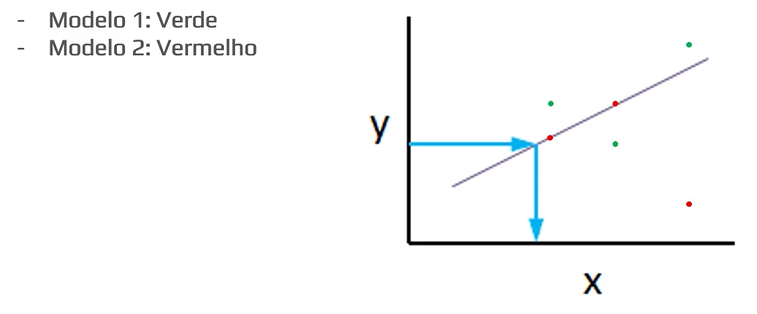

- Modelo Vermelho acerta cravado 2 vezes, mas erra por muito a terceira vez
- Modelo Verde erra todas as vezes por pouco
- Nesse cenário qual modelo escolher?

<br>

#### Métricas
Quando ficamos em dúvida, utilizamos métricas estatísticas para nos orientar a escolher o melhor modelo. Existem diversas métricas, usaremos basicamente 2
- R²
    - De 0 a 1 -> quanto maior, melhor
    - explicação lúdica: mede "o quanto" dos valores o modelo consegue explicar
    - ex: 0,92 (92%) significa que o modelo consegue explicar 92% de variância dos dados a partir das informações que você dá para ele
- RSME (Erro quadrático Médio ou Raiz do Erro Quadrático Médio)
    - pode ser qualquer valor positivo -> quanto menor, melhor
    - mede o "quanto o modelo erra"






### Passo 3: Escolher quais Modelos vamos usar e testar

Modelos que utilizaremos
- Linear Regression (Regressão Linear)
- Random Forest Regressor
- Extra Trees

<br>

####  Linear Regression
- Traça a "melhor reta"
- encontra a reta que minimiza os erros
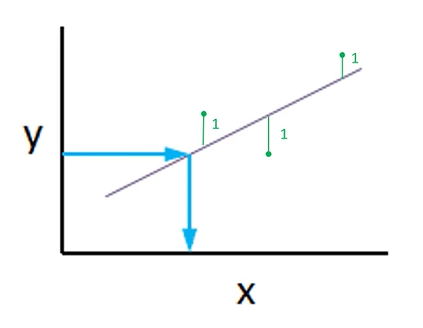

<br>

#### Random Forest e Extra Trees
- São Árvores de Decisão
- Utilizam basicamente a mesma lógica do jogo Akinator
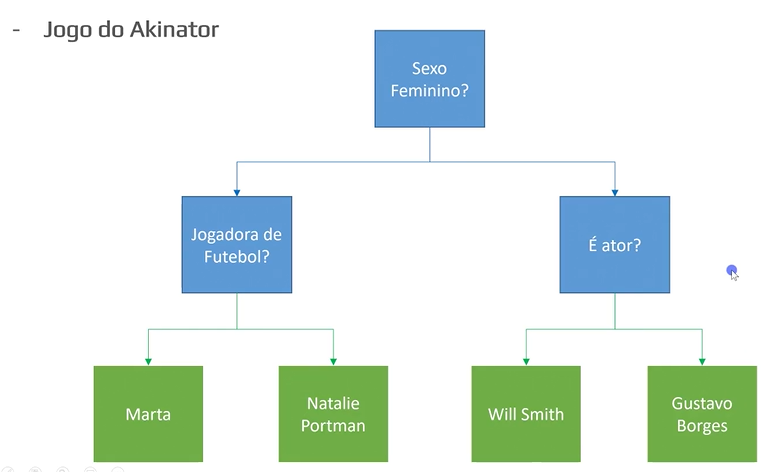

- **Random Forest**: cria várias árvores de decisão com pedaços menores e aleatórios da base de dados e calcula a média das árvores como resultado final.
    - escolhe a melhor pergunta
- **Extra Trees**: mesma essência do random forrest
    - escolhe uma pergunta aleatória

<br>




### Passo 4: Treinar e Testar os Modelos

**Separação da base de Dados em Treino e Teste**
- Separamos os dados aleatoriamente em 2 conjuntos (Treino e Teste)
- O treino são os dados que o seu modelo vai usar para aprender
- O teste são os dados que usamos para ver se o modelo aprendeu bem
    - Ex: 80% dados de treino e 20% dados de teste
- Avaliamos sempre o resultado nos testes, para não correr o risco de ovefitting

<br>

**Overfitting**
- Imagine que a gente tenha dado todos os dados para o modelo aprender
- Na teoria, o modelo aparentemente já viu de tudo, então seria melhor
- Na prática, corremos o risco do modelo ficar muito bom naqueles exemplos *específicos* e fazer previsões ruins para dados que nunca foram "vistos"
- Por esse motivo, precisamos de dados de teste

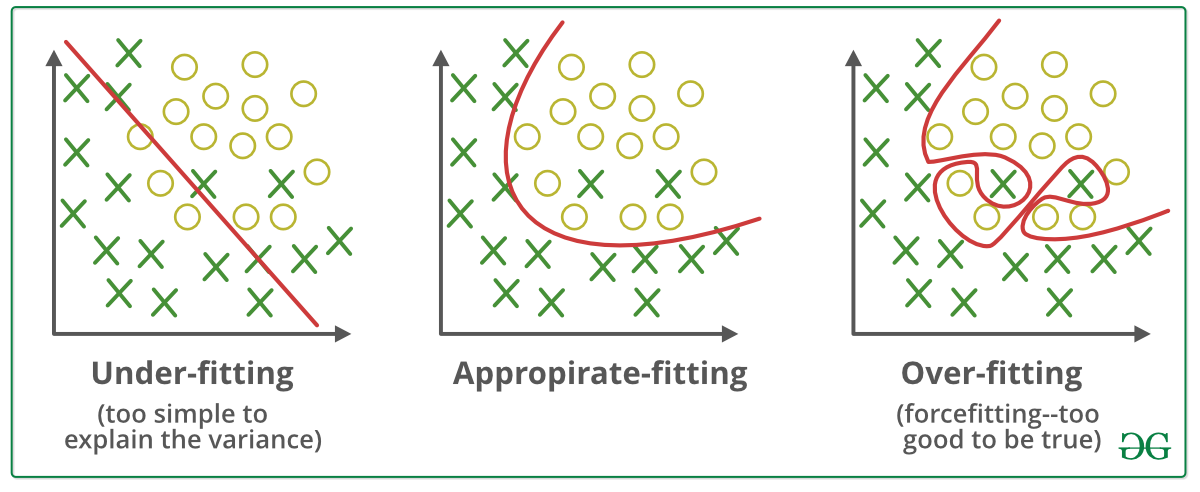


### Passo 5: Comparar os resultados do teste e escolher o melhor

**Análise dos Modelos pelas métricas que escolhemos**
- Calculamos o R² e o RSME paa cada modelo
- Escolhemos 1 métrica para ser a principal, digamos R² -> o modelo com maior R² vai ser considerado o melhor modelo
- Usaremos a 2ª métrica, nesse caso RSME, para critério de desempate ou para comparar modelos em que a métrica princiapal (R²) é parecida
- MAS, esses não são os únicos critérios:
    - tempo: um modelo que demora 1h para treinar e fazer prevvisões é pior que um modelo que demora 5min
    - quantidade de informações: um modelo que precise de menos informalçoes para funcionar (mais simples) é melhor do que um modelo mais complexo


### Passo 6: Analisar o melhor modelo mais a fundo

**Como esse modelo funciona?**
- Depois do modelo pronto e escolhido o melhor modelo analisamos como o melhor modelo funciona
- Identificamos a importância de cada feature para ver oportunidades de melhoria
    - Ex: se uma feature/coluna não é utilizada pelo nosso modelo, ou é pouco importante, podemos testar retirar essa feature e ver o resultado
- O resultado pode melhorar ou piorar, mas sempre importante olhar
    - métricas escolhidas (R² e RSME)
    - velocidade do modelo
    - simplicidade do modelo

### Passo 7: Otimizar e ajustar o melhor modelo

**Testamos a cada mudança que fazemos no modelo para fazer um ajuste final**
- Verificamos se as features identificadas no Passo 6 podem ser de fato retiradas
- Fazer outros testes, como um tratamento de outlier
- A cada etapa, treinamos e testamos o modelo, sempre comparando com o resultado original e o resultado anterior
- Objetivo:
    - Encontrar uma possível melhoria ao modelo (inclusive de previsão -> maior R² ou menor RSME)
    - Encontrar resultados semelhante com modelos mais rápidos e mais simples